In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

# Vorticity budget viewer<sup>TM</sup>

This notebook provides a widget to look at the sections of wind field and vorticity budget terms derived from it.

To run the notebook, just click **"Cell"** -> **"Run All"** in the menu panel above.

## Load modules

In [2]:
from collections import OrderedDict
import datetime
from ipywidgets import interact
import iris
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
import os
#
import umtools.irismode as umu
from pyveccalc import standard, tools

In [3]:
%matplotlib inline

In [4]:
mpl.rcParams['mathtext.default'] = 'regular'

## Read data

In [5]:
iris.FUTURE.netcdf_promote = True
um_res = 2200. # UM grid spacing

In [6]:
f = iris.load(os.path.join('um_plev_obs_1M_1200-1201.nc'))

In [7]:
umu.unrotate_wind(f, replace=True)
tcoord = f[0].coord('time')
#print(cf_units.num2date(tcoord.points, tcoord.units.name, tcoord.units.calendar))

In [8]:
cur_dt = tcoord.units.num2date(f[0].coord('time').points[0])
fcst_init_dt = tcoord.units.num2date(f[0].coord('forecast_reference_time').points[0])
fcst_len = cur_dt - fcst_init_dt
time_str = '{}'.format(cur_dt.strftime('%b %d %H:%M'))

In [9]:
lon0 = 11
lat0 = 75
mapkw_large = dict(lon1=lon0-16,lon2=lon0+40,lat1=lat0-9,lat2=lat0+7,tick_incr=[5.,1.],resolution='c',fill=True)
mapkw = dict(lon1=-2,lon2=12,lat1=71,lat2=75,tick_incr=[2.,1.], resolution='c', add_grid=True)

In [10]:
dims = 'zyx'

# Vorticity Budget calculation

### u, v, w for the current time step

In [11]:
u_cube = umu.get_cube(f, 'transformed_x_wind')[0,...]
v_cube = umu.get_cube(f, 'transformed_y_wind')[0,...]
w_cube = umu.get_cube(f, 'tendency')[0,...]

uwind, infodim = tools.prep_data(u_cube.data, dims)
vwind, infodim = tools.prep_data(v_cube.data, dims)
wwind, infodim = tools.prep_data(w_cube.data, dims)

Horizontal wind speed

In [12]:
wspd = np.sqrt(u_cube.data.copy()**2, v_cube.data.copy()**2)

Extract coordinate arrays

In [13]:
lon2d, lat2d = [i.points for i in u_cube.aux_coords[-2:]]
mcoords = umu.get_model_real_coords(w_cube, dims=dims)
plev = mcoords[dims.find('z')].points
# ilev = np.argmin(abs(plev[:] - jlev))
z = np.tile(plev*1e2, uwind.shape[-1]/plev.shape[0])

Create a pyveccalc Wind3D instance

In [14]:
Wi = standard.Wind3D(uwind, vwind, wwind, x=um_res, y=um_res, z=z, lats=lat2d.T)

### Calculate terms of vorticity budget in pressure coordinates

Horizontal advection, vertical advection, planetary vorticity advection, stretching term, tilting term...

In [15]:
hadv, vadv, planet_vort_adv, stretch, tilt = [tools.recover_data(ivar, infodim) for ivar in Wi.vort_tend_rhs()]
vo = tools.recover_data(Wi.vort_z(), infodim)

... and divergence

In [16]:
div = tools.recover_data(Wi.hdiv(), infodim)

### u, v, w for the next time step

In [17]:
u_cube = umu.get_cube(f, 'transformed_x_wind')[1,...]
v_cube = umu.get_cube(f, 'transformed_y_wind')[1,...]
w_cube = umu.get_cube(f, 'tendency')[1,...]

uwind, info3d = tools.prep_data(u_cube.data, dims)
vwind, info3d = tools.prep_data(v_cube.data, dims)
wwind, info3d = tools.prep_data(w_cube.data, dims)

Wi = standard.Wind3D(uwind, vwind, wwind, x=um_res, y=um_res, z=plev*1e2, lats=lat2d.T)

vo_p1 = tools.recover_data(Wi.vort_z(), info3d)
del Wi

#### Calculate local vorticity tendency

In [18]:
dvo_dt = (vo_p1 - vo)/60.

# Vertical cross-sections

Show only a subset of the original data

In [19]:
xsubset = slice(30, 160)
ysubset = slice(30, 160)

Pack up variables to plot

In [20]:
vardict1 = {
           'relative vorticity (s^-1)': dict(data=(vo[:,ysubset,xsubset]), scl=1e4, 
                                              conkw=dict(levels=np.arange(-20,22,2), cmap='RdBu_r')),
           'vorticity tendency (s^-2)': dict(data=dvo_dt[:,ysubset,xsubset], scl=1e7, 
                                              conkw=dict(levels=np.arange(-20,22,2), cmap='PuOr_r')),
           'HADV (s^-2)': dict(data=hadv[:,ysubset,xsubset], scl=1e7, 
                                conkw=dict(levels=np.arange(-20,22,2), cmap='PuOr_r')),
           'VADV (s^-2)': dict(data=vadv[:,ysubset,xsubset], scl=1e7, 
                                conkw=dict(levels=np.arange(-20,22,2), cmap='PuOr_r')),
           'STRETCH (s^-2)': dict(data=stretch[:,ysubset,xsubset], scl=1e7, 
                                   conkw=dict(levels=np.arange(-20,22,2), cmap='PuOr_r')),
           'TILT (s^-2)': dict(data=tilt[:,ysubset,xsubset], scl=1e7, 
                                conkw=dict(levels=np.arange(-20,22,2), cmap='PuOr_r'))
            }

In [21]:
vardict2 = {
            'omega (Pa/s)': dict(data=(w_cube.data.copy()[:,ysubset,xsubset]), scl=1, 
                                  conkw=dict(levels=[*range(-100,0,5)]+[*range(5,100,5)], colors='g')),
            'wind speed (m/s)': dict(data=wspd[:,ysubset,xsubset], scl=1, 
                                      conkw=dict(levels=range(5,50,5), colors='c')),
            'relative vorticity (s^-1)': dict(data=(vo[:,ysubset,xsubset]), scl=1e4, 
                                               conkw=dict(levels=[*range(-100,0,5)]+[*range(5,100,5)], colors='y'))
           }

In [22]:
zlev = plev[:]
lons = lon2d[ysubset,xsubset]
lats = lat2d[ysubset,xsubset]

Some styling...

In [23]:
annokw = dict(size=18, path_effects=[PathEffects.withStroke(linewidth=2,  foreground="w")])
annokw2 = dict(xy=(0.05, 0.95), xycoords='axes fraction', 
               va='center', ha='left', fontsize=14,
               bbox=dict(boxstyle='round', ec='w', fc='w', alpha=0.8))
lncol = 'k'
cbarkw = dict(orientation='vertical', shrink=0.9, fraction=0.05, pad=0.05) 

The main function to be transformed into a widget

In [24]:
def show_section(vrbl1, vrbl2, iz, ix, zoom, xz_ax):
    
    data1 = vrbl1['data'].copy()*vrbl1['scl']
    data2 = vrbl2['data'].copy()*vrbl2['scl']
    con1kw = vrbl1['conkw'] if 'conkw' in vrbl1 else {}
    con2kw = vrbl2['conkw'] if 'conkw' in vrbl2 else {}
    
    if 'cmap' in con1kw:
        if isinstance(con1kw['cmap'], str):
            con1kw['cmap'] = plt.cm.get_cmap(con1kw['cmap'])
            con1kw['cmap'].set_over((0.7, 0.0, 0.0))
            con1kw['cmap'].set_under('k')
    
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(30,8), gridspec_kw=dict(width_ratios=[1,2]))

    c1 = ax0.contourf(lons, lats, data1[iz,...], extend='both', **con1kw)
    c2 = ax0.contour(lons, lats, data2[iz,...], **con2kw)
    ax0.clabel(c2, inline=1, fmt='%3.0f', fontsize=14, colors=con2kw['colors'])
    ax0.tick_params(axis='both', which='major', labelsize=16)
    ax0.annotate('Level: {0} hPa'.format(round(plev[iz])), **annokw2)
    
    nz_c, ny_c, nx_c = [i//2 for i in data1.shape]
    if xz_ax == 'lon-p':
        xlab = 'Longitude, degrees'
        ylab = 'Central latitude'
        yval = lats[ix, nx_c]
        ha1 = 'right'
        ha2 = 'left'
        va1 = va2 = 'center'
        yslice = slice(nx_c - nx_c//(zoom+1), nx_c-1 + nx_c//(zoom+1))
        x = lons[ix,yslice]
        y = lats[ix,yslice]
        x2 = x
        data1_xz = data1[:,ix,yslice]
        data2_xz = data2[:,ix,yslice]

    elif xz_ax == 'lat-p':
        xlab = 'Latitude, degrees'
        ylab = 'Central longitude'
        yval = lats[ny_c, ix]
        ha1 = ha2 = 'center'
        va1 = 'top'
        va2 = 'bottom'
        yslice = slice(ny_c - ny_c//(zoom+1), ny_c-1 + ny_c//(zoom+1))
        x2 = lons[yslice,ix]
        y = lats[yslice,ix]
        x = y
        data1_xz = data1[:,yslice,ix] # np.rollaxis(vrbl,2,1)
        data2_xz = data2[:,yslice,ix]

    ax0.scatter(x2, y, c=lncol, s=2**3, edgecolors='')
    ax0.annotate('A', (x2[0], y[0]), ha=ha1, va=va1, **annokw)
    ax0.annotate('B', (x2[-1], y[-1]), ha=ha2, va=va2, **annokw)
    
    c3 = ax1.contourf(x, zlev, data1_xz, extend='both', **con1kw)
    c2p = ax1.contour(x, zlev, data2_xz, **con2kw)
    clbls = ax1.clabel(c2p, inline=1, fmt='%3.0f', fontsize=16, **con2kw)
    plt.setp(c2p.collections, path_effects=[
        PathEffects.withStroke(linewidth=3, foreground="w")])
    plt.setp(clbls, path_effects=[
        PathEffects.withStroke(linewidth=3, foreground="w")])
    ax1.hlines(zlev[iz], x[0], x[-1], linewidth=3, color=lncol)
    ax1.annotate('A', (x[0], zlev[iz]), ha='left', va='bottom', **annokw)
    ax1.annotate('B', (x[-1], zlev[iz]), ha='right', va='bottom', **annokw)
    ax1.invert_yaxis()
    ax1.set_ylabel('Pressure, hPa', fontsize=18)
    ax1.set_xlabel(xlab, fontsize=18)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.annotate(r'{0}: ${{{1}}}^\circ$'.format(ylab, round(yval,2)), **annokw2)
    
    cb1 = fig.colorbar(c3, ax=ax1, **cbarkw)
    scl_str = r'$\times10^{{{0}}}$'.format(-int(np.log10(vrbl1['scl'])))
    cb1.ax.set_xlabel(scl_str, fontsize=20) #+r' $s^{-1}$'
    cb1.set_ticks(con1kw['levels'][::2])
    cb1.ax.tick_params(labelsize=20)
    
    fig.suptitle("""Time: {cur_dt} ({fcst_init}+{fcst_len}h)""".format(cur_dt=time_str, 
                       fcst_init=fcst_init_dt.strftime('%b%d-%H:%M'),
                       fcst_len=int(fcst_len.total_seconds()/3600.)), fontsize=20)

# Cross-sections

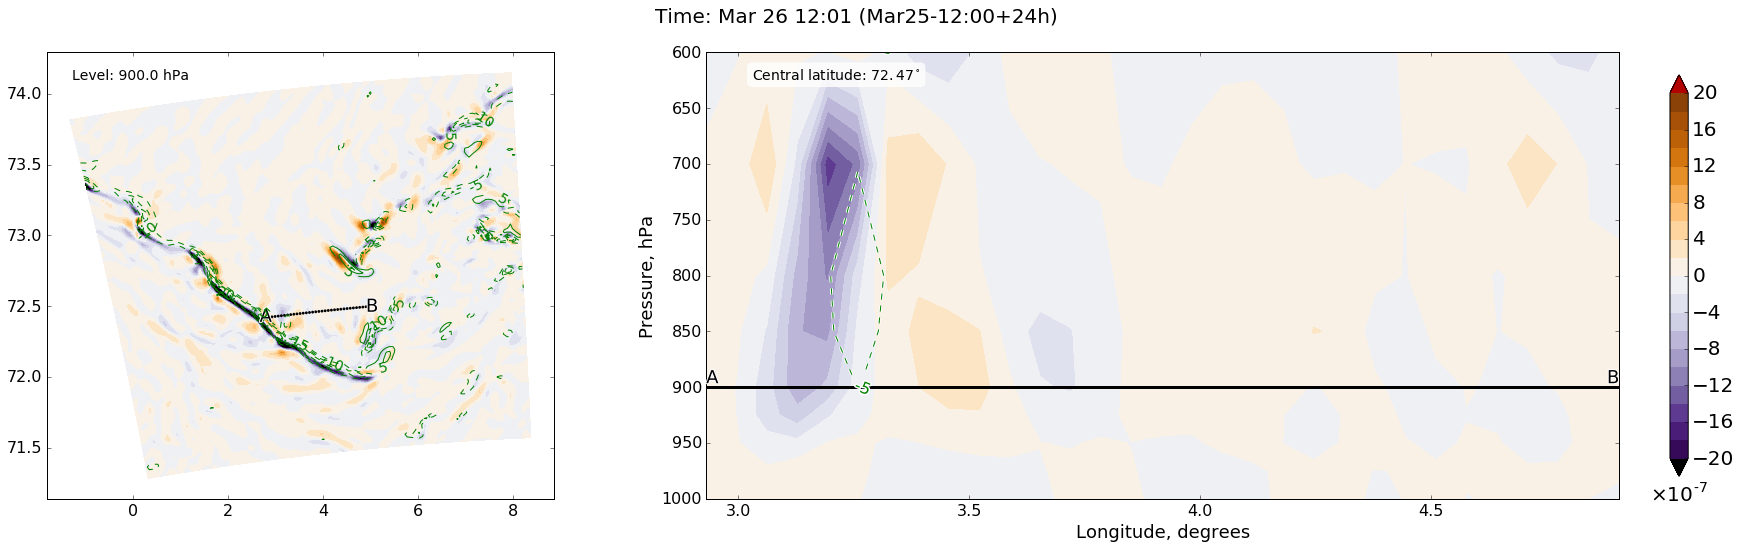

In [25]:
_ = interact(show_section, vrbl1=vardict1, vrbl2=vardict2,
             iz=(0,len(zlev)-1,1), ix=(0,100,5), zoom=(0,6,1), 
             xz_ax={'longitude-pressure':'lon-p', 'latitude-pressure':'lat-p'})